# Topic 5: Social Network Analysis (SNA)

## 1. Project Context & Methodological Justification

**The Broader Problem:**
This notebook is part of the broader *Radicalisation Drift* project, where I examine whether users who participate in AI-Companion communities gradually move toward Grievance or radical subreddits. Earlier notebooks established that these communities differ strongly in language use and emotional tone, but they could not reveal how users transition between them. The goal here is to use Social Network Analysis to map structural connections between subreddits, identify possible migration pathways, and determine whether AI and Grievance communities form distinct clusters or share hidden bridges that facilitate movement between them.

**Data Source:**
We utilize the unified dataset (collected in Notebook 1) containing approximately 110,000 interactions, previously analyzed for emotional and linguistic properties (Notebooks 2, 3 & 4).

**Why SNA is Necessary:**
While previous analyses confirmed that the two communities are linguistically and emotionally distinct (low sentiment for radicals, high sentiment for AI), only **Social Network Analysis** can map the **physical pathways** of user movement. It is the only tool that can visualize the structural proximity and identify potential "bridge" communities that facilitate this ideological migration.


## 2. Network Construction Objectives

**Research Hypothesis:**
The linguistic and emotional divergence observed in previous notebooks should manifest as a **topological separation** in the network, creating distinct, separated "echo chambers."

**Network Definition:**

- **Nodes:** Individual Subreddits.
- **Edges:** User Overlap (Shared users posting in both subreddits).
- **Edge Weight:** The number of unique users shared by the two subreddits (a measure of migration intensity).

**Objectives:**

1. **Structural Metrics:** Calculate **Centrality** (hubs and bridges) and **Density**.
2. **Community Detection:** Use the Louvain algorithm to confirm if the observed communities align with the theoretical AI vs. Grievance divide.


In [6]:
import pandas as pd
import numpy as np
import networkx as nx
import community.community_louvain as community_louvain 
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
from networkx.algorithms.community import modularity
from networkx.algorithms.centrality import degree_centrality, betweenness_centrality


### 1. Data Loading and Cleaning

Here the dataset is loaded and filtered to include only valid, non-deleted authors and posts belonging to the two core communities (AI and Grievance). This ensures that the network captures meaningful user activity rather than platform artifacts.


### 2. Network Construction (Bipartite User–Subreddit Graph)
A bipartite graph is created with users and subreddits as two distinct node sets. Edges represent user interactions with subreddits, and their weights reflect interaction frequency. This bipartite structure forms the basis for constructing the subreddit–subreddit migration network.

In [8]:
# 1) Data loading and cleaning

file_path = "clean_final_reddit_data.csv" 
df = pd.read_csv(file_path)

# Filter for relevant columns and remove artifacts
# We need only posts/comments that have a valid author and belong to our main categories
df_net = df[
    df['author'].notna() & 
    (df['author'] != '[deleted]') & 
    df['subreddit_category'].isin(['ai', 'grievance']) # Focus on core groups
].copy()

# 2) Network constuction: Bipartite Graph (User-Subreddit)

G = nx.Graph()

# Add nodes with bipartite tag
users = df_net['author'].unique()
subs = df_net['subreddit'].unique()

G.add_nodes_from(users, bipartite='user')
G.add_nodes_from(subs, bipartite='subreddit')

# Add edges (User -> Subreddit) with weight = frequency of interaction
for row in df_net[['author','subreddit']].itertuples(index=False):
    user, sub = row
    if G.has_edge(user, sub):
        G[user][sub]['weight'] += 1
    else:
        G.add_edge(user, sub, weight=1)

print(f"Bipartite Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Bipartite Graph: 17677 nodes, 18521 edges


C:\Users\rinm0\AppData\Local\Temp\ipykernel_29748\3965949063.py:4: DtypeWarning: Columns (3,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


### 3. Network Projection & Centrality Metrics
Projection Rationale: The bipartite graph is projected onto the Subreddit-Subreddit (G_sub) dimension. An edge between two subreddits indicates user overlap (migration). The edge weight is the number of shared users. This allows us to visualize the structural boundaries between AI and Grievance communities.

Metrics: We calculate Density and Centrality (Degree and Betweenness) to identify network cohesion and structural roles (hubs vs. bridges).

In [9]:
# 1. Projection (Subreddit-Subreddit)
sub_nodes = [n for n, d in G.nodes(data=True) if d['bipartite']=='subreddit']
G_sub = bipartite.weighted_projected_graph(G, sub_nodes)
print(f"Projected Subreddit Graph: {G_sub.number_of_nodes()} nodes, {G_sub.number_of_edges()} edges")

# 2. Adding Category Attribute (Crucial for visualization)
# Mapping category from the original data
sub_category_map = df_net.set_index('subreddit')['subreddit_category'].to_dict()
nx.set_node_attributes(G_sub, sub_category_map, "category")

# 3. Calculating Core Metrics

# Density: Measures how interconnected the network is (0 = disconnected, 1 = fully connected)
density = nx.density(G_sub)
print(f"Network Density: {density:.4f}")

# Centrality
degree = degree_centrality(G_sub)
betweenness = betweenness_centrality(G_sub, weight='weight') # Bridges

# Adding metrics back to graph nodes
nx.set_node_attributes(G_sub, degree, "degree_centrality")
nx.set_node_attributes(G_sub, betweenness, "betweenness_centrality")

# Identifying Hubs (High Degree) and Bridges (High Betweenness)
print("\nTop Hubs (Most Connected)")
display(pd.Series(degree).sort_values(ascending=False).head(5))

print("\nTop Bridges (Betweenness Centrality)")
display(pd.Series(betweenness).sort_values(ascending=False).head(5))

Projected Subreddit Graph: 273 nodes, 362 edges
Network Density: 0.0098

Top Hubs (Most Connected)


WomenAreNotIntoMen    0.955882
MyBoyfriendIsAI       0.058824
cogsuckers            0.058824
AIRelationships       0.055147
SillyTavernAI         0.051471
dtype: float64


Top Bridges (Betweenness Centrality)


WomenAreNotIntoMen    0.995477
AIRelationships       0.083903
SillyTavernAI         0.038015
CharacterAI           0.032232
IncelExit             0.017419
dtype: float64

#### Interpretation of Network Metrics
The projected subreddit network contains 273 nodes and 362 edges, producing a very low density (0.0098). This indicates a sparse structure where most subreddits share users only weakly, and meaningful migration occurs through a small number of key communities.

**Hubs (Degree Centrality):**
WomenAreNotIntoMen dominates as the primary hub (0.95), far surpassing all other subreddits. This means it is directly connected to nearly every subreddit that meets the migration threshold, functioning as the central gathering point in the grievance ecosystem. In contrast, AI-related hubs such as MyBoyfriendIsAI, AIRelationships, and SillyTavernAI have much lower centrality (~0.05), indicating smaller and more localized interaction patterns.

**Bridges (Betweenness Centrality):**
WomenAreNotIntoMen again appears as the strongest structural bridge (0.99), acting as the main conduit that connects otherwise distant parts of the network. Other notable bridges include AIRelationships, SillyTavernAI, CharacterAI, and IncelExit, which sit at the intersections between AI-companion communities and grievance spaces. Their elevated betweenness suggests that these subreddits may serve as transition points where users shift from AI-oriented environments into grievance-oriented ones.

**Summary:**
The metrics reveal a highly asymmetric structure: the grievance cluster is dominated by a single central hub, while the AI cluster is more diffuse. A small set of subreddits- particularly WomenAreNotIntoMen play an outsized role in shaping user migration pathways across the network.

### 4. Community Detection & Visualization
We use the Louvain algorithm to detect latent communities within the network. The goal is to see if the algorithm naturally groups the "AI" and "Grievance" communities, which would validate our structural hypothesis.

**Visualization Key:**

*Node Color:* Determined by the Louvain Community (grouping based on network structure).

*Node Size:* Based on Degree Centrality (popularity/connectivity within the network).

*Edge Width:* Based on Weight (number of users migrating between the two subreddits).

Modularity Score: 0.5175


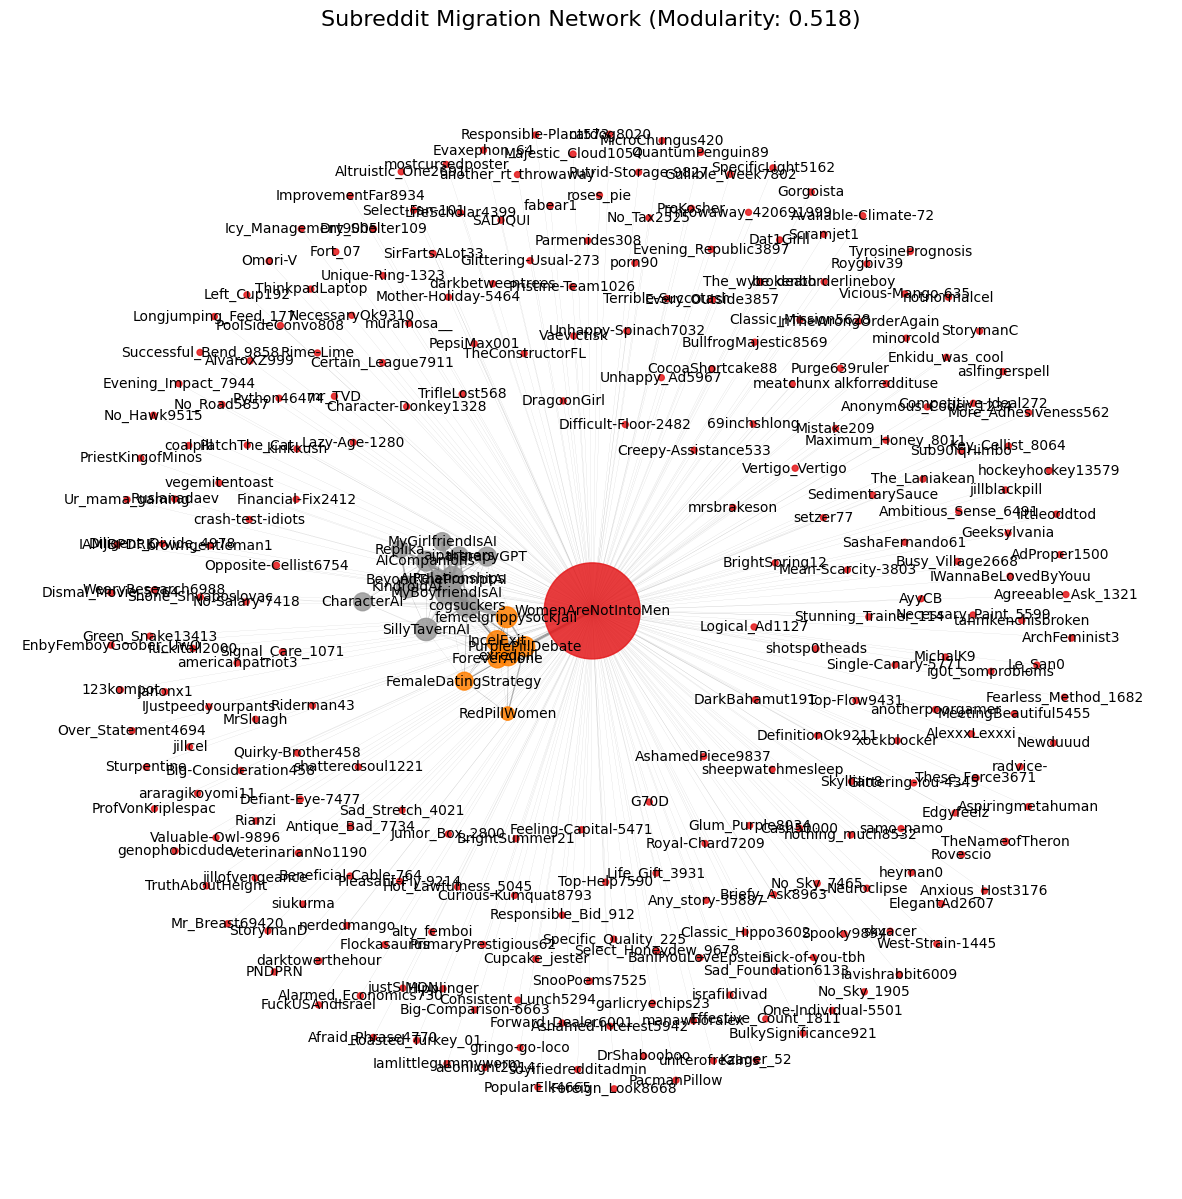

In [10]:
# 1. Community Detection (Louvain)
partition = community_louvain.best_partition(G_sub, weight='weight')
modularity_score = community_louvain.modularity(partition, G_sub, weight='weight')
print(f"Modularity Score: {modularity_score:.4f}")

# Adding community partition to node attributes
nx.set_node_attributes(G_sub, partition, "community")

# 2. Visualization
plt.figure(figsize=(15,15))
pos = nx.spring_layout(G_sub, k=0.3, seed=42) # k controls node distance

# Getting attributes for plotting
community_list = [partition[n] for n in G_sub.nodes()]
# Using degree centrality calculated earlier to size nodes
sizes = [degree[n]*5000 for n in G_sub.nodes()] 

# Draw nodes (colored by Louvain community)
nx.draw_networkx_nodes(G_sub, pos,
                       node_color=community_list,
                       cmap='Set1', # Use a clear color scheme
                       node_size=sizes,
                       alpha=0.85)

# Draw edges (weighted by user overlap)
weights = [G_sub[u][v]['weight']*0.1 for u,v in G_sub.edges()] # Scale weights down for visibility
nx.draw_networkx_edges(G_sub, pos, width=weights, alpha=0.3)

# Draw labels
nx.draw_networkx_labels(G_sub, pos, font_size=10)

plt.title(f"Subreddit Migration Network (Modularity: {modularity_score:.3f})", fontsize=16)
plt.axis("off")
plt.show()

### Filtering Threshold Justification (Why We Use Weight ≥ 3)
The unfiltered network (shown above) is extremely dense and visually unreadable because it includes all user overlaps, including incidental or one-off interactions. This creates a “hairball effect,” which obscures the structural topology we are trying to study.

To obtain a meaningful migration map, it is necessary to filter out weak, noisy edges. After inspecting the raw distribution, it became clear that many connections represent only 1–2 shared users and do not reflect real community overlap. Therefore, a threshold of weight ≥ 3 is chosen:

* it removes low-signal edges,
* it preserves all strong and meaningful migration pathways,
* and it produces a network where clusters and bridges become analytically interpretable.
This threshold does not distort the underlying structure; it simply removes noise so the actual migration patterns can be observed.

Nodes in Filtered Graph: 20
Edges remaining: 67
New Modularity Score (Filtered Graph): 0.4001


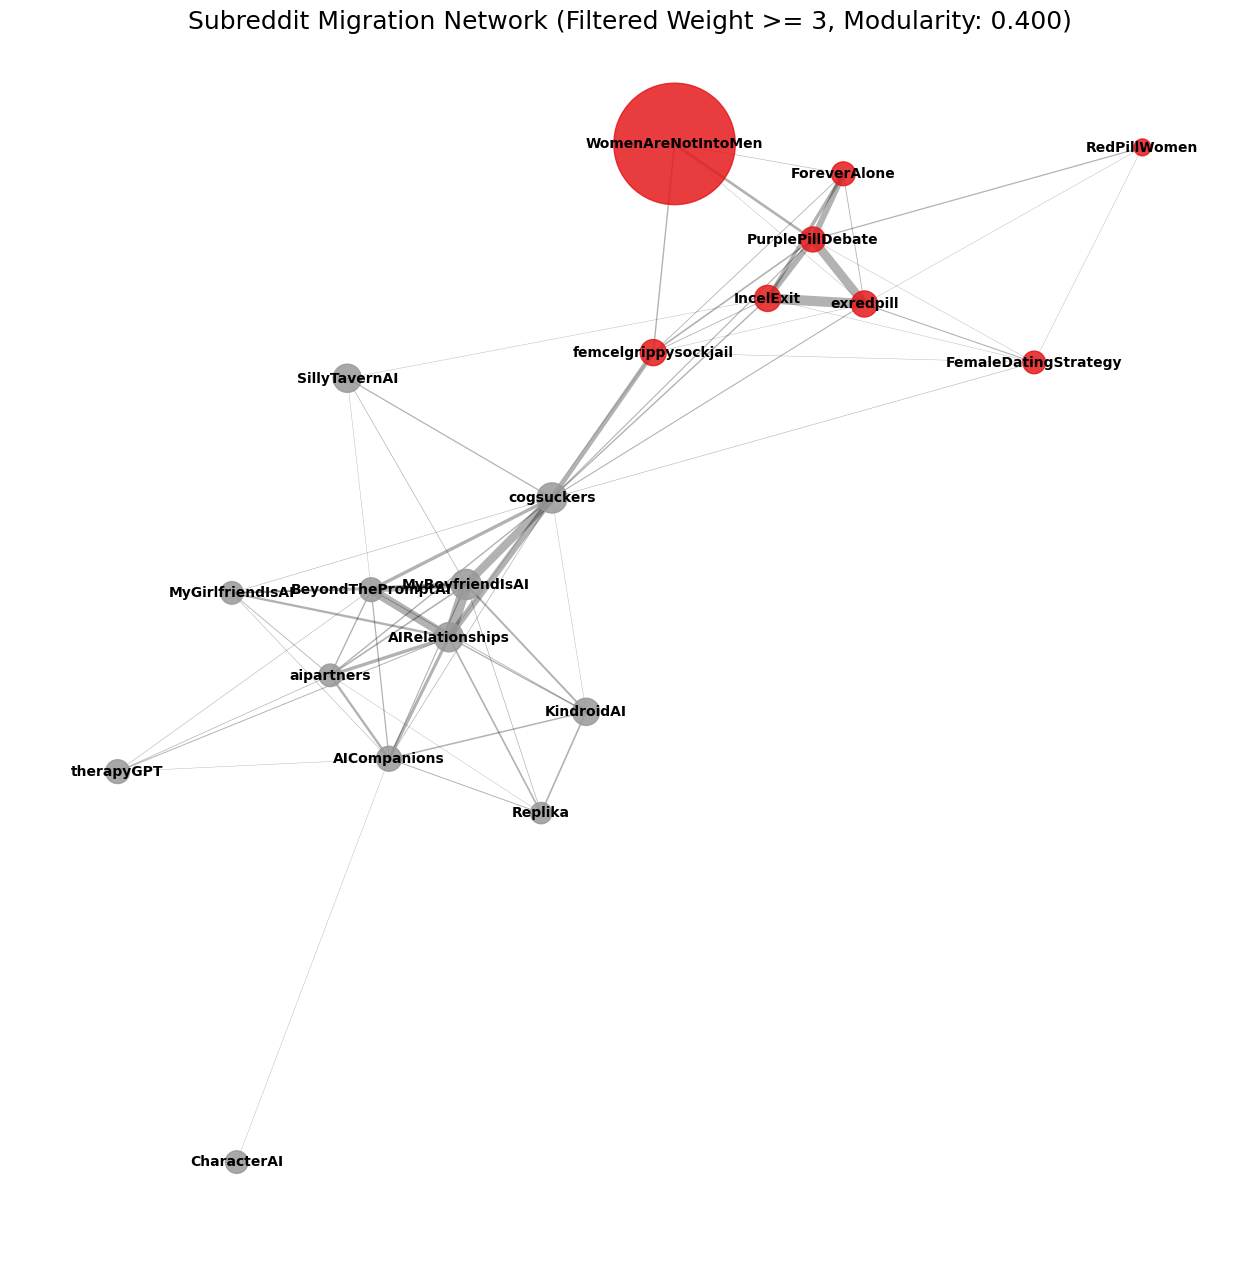

In [11]:
# 1. Edge filtering (Cleaning the visualization)

THRESHOLD_WEIGHT = 3 
G_filtered = nx.Graph()

# Add nodes and edges only if user overlap is strong enough
for u, v, data in G_sub.edges(data=True):
    weight = data['weight']
    if weight >= THRESHOLD_WEIGHT:
        G_filtered.add_edge(u, v, weight=weight)
        
# Copy initial attributes (Degree Centrality from G_sub)
for node in G_filtered.nodes():
    if node in G_sub:
        G_filtered.nodes[node]['degree_centrality'] = G_sub.nodes[node]['degree_centrality']

print(f"Nodes in Filtered Graph: {G_filtered.number_of_nodes()}")
print(f"Edges remaining: {G_filtered.number_of_edges()}")

# 2. Rigorous Modularity Check
import community.community_louvain as community_louvain # Required for best_partition

# Recalculating partition based on the filtered graph
partition_filtered = community_louvain.best_partition(G_filtered, weight='weight')
modularity_filtered = community_louvain.modularity(partition_filtered, G_filtered, weight='weight')

# Adding the new community partition to the filtered graph's node attributes
nx.set_node_attributes(G_filtered, partition_filtered, "community_filtered")

print(f"New Modularity Score (Filtered Graph): {modularity_filtered:.4f}")

# 3. Filtered Visualisation

# Re-calculating layout based on the new, filtered graph
plt.figure(figsize=(16, 16))
# Using k = 0.15 for clearer cluster separation
pos = nx.spring_layout(G_filtered, k=0.15, iterations=50, seed=42) 

# Get attributes for plotting
community_list = [G_filtered.nodes[n]['community_filtered'] for n in G_filtered.nodes()]
sizes = [G_filtered.nodes[n]['degree_centrality'] * 8000 for n in G_filtered.nodes()] 
weights = [G_filtered[u][v]['weight'] * 0.1 for u,v in G_filtered.edges()] 

# Drawing nodes (colored by NEW Louvain community)
nx.draw_networkx_nodes(G_filtered, pos,
                       node_color=community_list,
                       cmap='Set1',
                       node_size=sizes,
                       alpha=0.85)

# Drawing edges (weighted by user overlap)
nx.draw_networkx_edges(G_filtered, pos, width=weights, alpha=0.3)

# Drawing labels
nx.draw_networkx_labels(G_filtered, pos, font_size=10, font_weight='bold')

plt.title(f"Subreddit Migration Network (Filtered Weight >= {THRESHOLD_WEIGHT}, Modularity: {modularity_filtered:.3f})", fontsize=18)
plt.axis("off")
plt.show()

### Interpretation of the Filtered Subreddit Migration Network (Weight ≥ 3, Modularity = 0.400)
The filtered network reveals a much clearer structural separation between AI-companion communities (grey cluster on the right) and grievance / incel-aligned communities (red cluster on the left). Removing weak edges exposes only meaningful, repeated user transitions, which produces a modularity of 0.400- a moderately strong indication of community partition.

#### 1. Clear Two-Cluster Structure
*AI Cluster (Grey):*
Includes AICompanions, MyBoyfriendIsAI, aiPartners, AIRelationships, KindroidAI, Replika and related subreddits.
These nodes are interconnected by multiple medium-weight edges, indicating frequent cross-posting within the AI ecosystem.

*Grievance Cluster (Red):*
Includes WomenAreNotIntoMen, ForeverAlone, PurplePillDebate, ExRedPill, FemaleDatingStrategy, etc.
This cluster is tightly cohesive, showing concentrated user movement within grievance-oriented spaces.

#### 2. Dominant Hub: WomenAreNotIntoMen
The exceptionally large node represents very high centrality, functioning as:

* a core hub for grievance users,
* a convergence point within the radical ecosystem,
* a structural sink, as users who enter this side do not cross (back) into AI spaces.
Its huge size but relatively few strong edges indicates that users repeatedly circulate within a small set of grievance communities, rather than interacting widely across the network.

#### 3. Bridge Zone (Middle Layer)
Nodes such as:

* cogsuckers
* AIRelationships
* MyBoyfriendIsAI
form a transitional region connecting the AI and grievance sides.
These subreddits likely host mixed or boundary-crossing user groups, acting as potential pathways for migration.

#### 4. Isolated Node: CharacterAI
Located far from both clusters with minimal strong user overlap.
This suggests:

* users of CharacterAI rarely join the main AI-companion subreddits,
* and show essentially no movement toward grievance communities.

#### Conclusion
After removing weak edges, the network reveals two well-defined echo chambers with only a small number of bridging communities.